# 03 — IFRS 9 Staging and Rating Migration Analysis

This notebook introduces a simplified **IFRS 9 credit risk framework** based on the synthetic
loan portfolio used in the previous notebooks.

The focus is on:
- credit risk staging (Stage 1 / Stage 2 / Stage 3),
- delinquency-based triggers (Days Past Due),
- internal rating transitions,
- migration matrices,
- Expected Loss allocation by stage.

The analysis is designed as a **conceptual and educational illustration** of IFRS 9 mechanics,
not as a full regulatory implementation.


## 1. Purpose and IFRS 9 context

IFRS 9 requires financial institutions to recognise expected credit losses (ECL)
based on changes in credit risk since initial recognition.

Unlike portfolio-level risk metrics or concentration analysis,
IFRS 9 focuses on the **evolution of credit quality over time** at individual exposure level.

This notebook addresses the following questions:

- How are loans classified into IFRS 9 stages?
- How can delinquency (DPD) be used as a staging trigger?
- How do internal ratings migrate over time?
- How can migration matrices be constructed?
- How is Expected Loss distributed across stages?

## 2. Dataset and key inputs

The analysis is based on the synthetic loan portfolio dataset generated in this repository.

Key inputs used in this notebook include:
- `pd_1y` – 1-year Probability of Default
- `lgd` – Loss Given Default
- `ead` – Exposure at Default
- `days_past_due` (DPD)
- `is_default` – default indicator
- `internal_rating` – current internal credit rating

All data is fully synthetic and used for demonstration purposes only.

## 3. IFRS 9 staging overview

Under IFRS 9, exposures are classified into three stages based on
**changes in credit risk since initial recognition**, not solely on current default status.

The staging framework links credit risk assessment with the timing
and amount of expected credit loss recognition.

---
### Stage 1 – Performing exposures

Stage 1 includes exposures that have **not experienced a significant increase in credit risk**
since initial recognition.

Typical characteristics:
- performing loans with low delinquency,
- stable or improving credit quality,
- no significant adverse changes in risk indicators.

For Stage 1 exposures, banks recognise **12-month Expected Credit Loss (ECL)**,
representing losses from default events that may occur within the next 12 months.

---
### Stage 2 – Underperforming exposures

Stage 2 includes exposures that have experienced a
**significant increase in credit risk (SICR)** since initial recognition,
but are not credit-impaired.

Typical characteristics:
- increased delinquency (e.g. ≥ 30 days past due),
- deterioration in internal credit ratings,
- adverse changes in borrower financial condition or risk outlook.

For Stage 2 exposures, banks recognise **lifetime Expected Credit Loss**,
reflecting all expected losses over the remaining lifetime of the exposure.

---
### Stage 3 – Credit-impaired exposures

Stage 3 includes **credit-impaired or defaulted exposures**.

Typical characteristics:
- default events have occurred,
- borrower is unlikely to pay without realisation of collateral,
- significant financial distress.

For Stage 3 exposures, banks recognise **lifetime Expected Credit Loss**,
and interest income is typically calculated on a net basis
(after impairment allowances).

---

This three-stage framework ensures that credit losses are recognised
earlier as credit risk increases, providing a forward-looking view
of portfolio credit quality.


## 4. Staging logic and DPD-based triggers

In this notebook, a simplified staging approach is applied using
**Days Past Due (DPD)** and default indicators.

The staging logic is defined as follows:

- **Stage 1:** DPD < 30 days and not defaulted  
- **Stage 2:** DPD ≥ 30 days and not defaulted  
- **Stage 3:** Defaulted exposures (`is_default = 1`)

This approach reflects common industry practices and supervisory guidance,
while remaining intentionally simple for demonstration purposes.

In [3]:
# Loading necessary libraries and reading the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.float_format", "{:,.4f}".format)

file_path = "../data/loan_portfolio.xlsx"
df = pd.read_excel(file_path)

print("Dataset loaded successfully.")
print("Shape:", df.shape)

# Copy the DataFrame for IFRS 9 analysis (clean and consistent)
df_ifrs9 = df.copy()

# Display initial rows to understand the structure
# Add a new column 'ifrs9_stage' based on the IFRS 9 classification rules
df_ifrs9["ifrs9_stage"] = "Stage 1"
df_ifrs9.loc[df_ifrs9["days_past_due"] >= 30, "ifrs9_stage"] = "Stage 2"
df_ifrs9.loc[df_ifrs9["is_default"] == 1, "ifrs9_stage"] = "Stage 3"

df_ifrs9[["loan_id", "days_past_due", "is_default", "ifrs9_stage"]].head(10)


Dataset loaded successfully.
Shape: (1000, 18)


,loan_id,days_past_due,is_default,ifrs9_stage
0,1,307,1,Stage 3
1,2,14,0,Stage 1
2,3,13,0,Stage 1
3,4,24,0,Stage 1
4,5,11,0,Stage 1
5,6,10,0,Stage 1
6,7,20,0,Stage 1
7,8,0,0,Stage 1
8,9,22,0,Stage 1
9,10,0,0,Stage 1


## 5. Distribution of exposures by IFRS 9 stage

Before analysing rating migration and losses, we examine:
- number of loans by stage,
- total EAD by stage,
- relative share of each stage in the portfolio.

This provides a first indication of overall portfolio credit quality
from an IFRS 9 perspective.

In [4]:
stage_counts = (
    df_ifrs9.groupby("ifrs9_stage")["loan_id"]
    .count()
    .to_frame("loan_count")
)
stage_counts

,loan_count
ifrs9_stage,
Stage 1,950
Stage 3,50


In [5]:
total_ead = df_ifrs9["ead"].sum()

stage_ead = (
    df_ifrs9.groupby("ifrs9_stage")["ead"]
    .sum()
    .to_frame("total_ead")
)

stage_ead["share_of_portfolio_pct"] = stage_ead["total_ead"] / total_ead * 100
stage_ead

,total_ead,share_of_portfolio_pct
ifrs9_stage,,
Stage 1,"34,897,814.1953",93.1574
Stage 3,"2,563,318.8447",6.8426


In [6]:
# Calculate expected loss for each loan
df_ifrs9["expected_loss"] = df_ifrs9["pd_1y"] * df_ifrs9["lgd"] * df_ifrs9["ead"]

## 6. Internal rating transitions

Internal credit ratings are expected to migrate over time
as borrowers’ credit quality improves or deteriorates.

In this section we analyse:
- current vs previous internal ratings,
- upgrades and downgrades,
- stability of high-quality vs weaker rating buckets.

The rating transitions are fully synthetic and generated
to illustrate realistic migration behaviour.

In [7]:
# --- Synthetic rating transitions setup (t0 -> t1) ---
import numpy as np
np.random.seed(42)

ratings = ["AAA", "AA", "A", "BBB", "BB/B"]  # order: best -> worst

def generate_previous_rating(current_rating: str) -> str:
    # Mostly stable, some upgrades/downgrades
    move = np.random.choice(["stable", "upgrade", "downgrade"], p=[0.70, 0.15, 0.15])

    # If rating not in list, keep stable (safety)
    if current_rating not in ratings:
        return current_rating

    idx = ratings.index(current_rating)

    if move == "upgrade" and idx > 0:
        return ratings[idx - 1]
    elif move == "downgrade" and idx < len(ratings) - 1:
        return ratings[idx + 1]
    else:
        return current_rating

# Define ratings at t1 and generate t0
df_ifrs9["rating_t1"] = df_ifrs9["internal_rating"]
df_ifrs9["rating_t0"] = df_ifrs9["rating_t1"].apply(generate_previous_rating)

print("=== Sample rating transitions ===")
df_ifrs9[["loan_id", "rating_t0", "rating_t1"]].head(10)

=== Sample rating transitions ===


,loan_id,rating_t0,rating_t1
0,1,BB/B,BB/B
1,2,BB/B,BB/B
2,3,BBB,BB/B
3,4,BBB,BBB
4,5,BB/B,BB/B
5,6,BB/B,BB/B
6,7,BBB,BBB
7,8,BB/B,BBB
8,9,A,A
9,10,A,BBB


In [8]:
transition_summary = (
    df_ifrs9.assign(
        transition=np.where(
            df_ifrs9["rating_t0"] == df_ifrs9["rating_t1"], "Stable",
            np.where(
                df_ifrs9["rating_t0"].map(ratings.index) > df_ifrs9["rating_t1"].map(ratings.index),
                "Upgrade",
                "Downgrade"
            )
        )
    )
    .groupby("transition")["loan_id"]
    .count()
    .to_frame("count")
)

transition_summary["share_pct"] = transition_summary["count"] / transition_summary["count"].sum() * 100
transition_summary


,count,share_pct
transition,,
Downgrade,130,13.0000
Stable,766,76.6000
Upgrade,104,10.4000


## 7. Rating migration matrix

To summarise rating movements, we construct a **migration matrix**:

- rows represent ratings at time t₀,
- columns represent ratings at time t₁,
- each cell shows the proportion of exposures migrating between ratings.

The migration matrix is a standard tool in credit risk management
and is widely used for portfolio monitoring and model validation.

In [15]:
# --- Rating migration matrix (t0 -> t1) ---

migration_matrix = pd.crosstab(
    df_ifrs9["rating_t0"],
    df_ifrs9["rating_t1"],
    normalize="index"
).round(3)
rating_order = ["AAA", "AA", "A", "BBB", "BB/B"]

migration_matrix = migration_matrix.reindex(
    index=rating_order,
    columns=rating_order
)
print("=== Rating migration matrix (row-normalized) ===")
migration_matrix


=== Rating migration matrix (row-normalized) ===


rating_t1,AAA,AA,A,BBB,BB/B
rating_t0,,,,,
AAA,0.8240,0.1760,0.0000,0.0000,0.0000
AA,0.0780,0.6670,0.2560,0.0000,0.0000
A,0.0000,0.0650,0.6510,0.2850,0.0000
BBB,0.0000,0.0000,0.0810,0.7800,0.1400
BB/B,0.0000,0.0000,0.0000,0.1680,0.8320


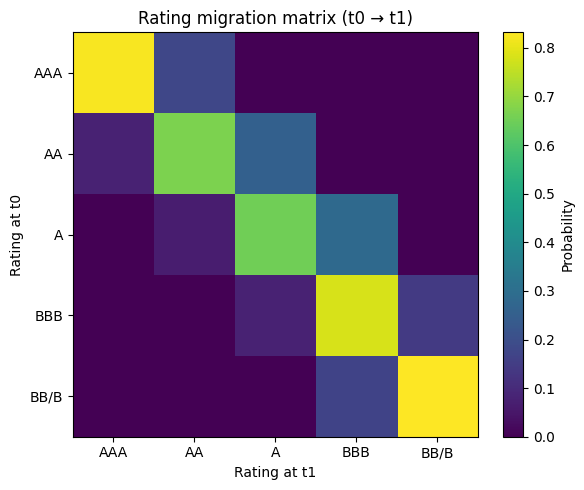

In [16]:
plt.figure(figsize=(6, 5))
plt.imshow(migration_matrix.values, aspect="auto")
plt.xticks(range(len(migration_matrix.columns)), migration_matrix.columns)
plt.yticks(range(len(migration_matrix.index)), migration_matrix.index)
plt.colorbar(label="Probability")
plt.title("Rating migration matrix (t0 → t1)")
plt.xlabel("Rating at t1")
plt.ylabel("Rating at t0")
plt.tight_layout()
plt.show()

### Interpretation of the migration matrix

The migration matrix shows rating movements from time t₀ (rows) to time t₁ (columns).
Most exposures remain on the diagonal, indicating rating stability.
Off-diagonal entries reflect upgrades and downgrades, with limited extreme movements,
which is consistent with realistic credit portfolio behaviour.

## 8. Expected Loss by IFRS 9 stage

Expected Loss is analysed by IFRS 9 stage to illustrate:
- how risk is distributed across Stage 1, Stage 2 and Stage 3,
- the impact of staging on loss allocation,
- the dominance of lifetime ECL in later stages.

The analysis is based on the Expected Loss calculations introduced
in Notebook 01.

In [17]:
# --- Expected Loss calculation (loan-level) ---

df_ifrs9["expected_loss"] = (
    df_ifrs9["pd_1y"] * df_ifrs9["lgd"] * df_ifrs9["ead"]
)

print("Expected Loss column added.")
df_ifrs9[["loan_id", "ifrs9_stage", "expected_loss"]].head()

Expected Loss column added.


,loan_id,ifrs9_stage,expected_loss
0,1,Stage 3,"9,977.2665"
1,2,Stage 1,"1,066.7912"
2,3,Stage 1,"1,627.3256"
3,4,Stage 1,"2,462.7931"
4,5,Stage 1,828.3209


In [18]:
# --- Expected Loss aggregation by IFRS 9 stage ---

total_el = df_ifrs9["expected_loss"].sum()

el_by_stage = (
    df_ifrs9
    .groupby("ifrs9_stage")["expected_loss"]
    .sum()
    .to_frame(name="total_expected_loss")
)

el_by_stage["share_of_total_el_pct"] = (
    el_by_stage["total_expected_loss"] / total_el * 100
)

print("=== Expected Loss by IFRS 9 stage ===")
el_by_stage

=== Expected Loss by IFRS 9 stage ===


,total_expected_loss,share_of_total_el_pct
ifrs9_stage,,
Stage 1,"649,945.5682",89.2162
Stage 3,"78,560.3528",10.7838


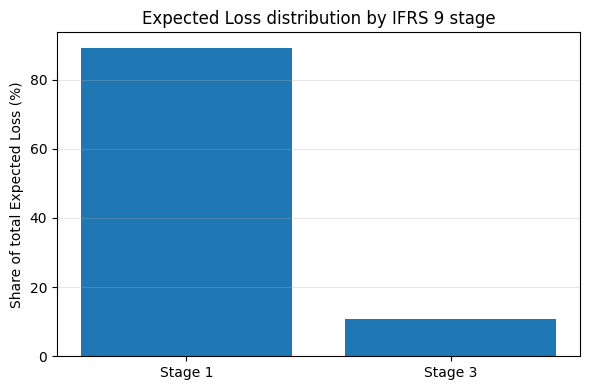

In [19]:
plt.figure(figsize=(6, 4))
plt.bar(el_by_stage.index, el_by_stage["share_of_total_el_pct"])
plt.title("Expected Loss distribution by IFRS 9 stage")
plt.ylabel("Share of total Expected Loss (%)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation of Expected Loss by stage

The distribution of Expected Loss across IFRS 9 stages highlights the
progressive nature of impairment recognition.

- **Stage 1** exposures typically contribute a relatively small share of total Expected Loss,
  reflecting performing loans with limited credit deterioration.
- **Stage 2** exposures show a materially higher loss contribution due to lifetime ECL recognition
  following a significant increase in credit risk.
- **Stage 3** exposures concentrate a large share of Expected Loss, as expected for credit-impaired loans.

This pattern is consistent with IFRS 9 principles and confirms the strong link
between staging, credit quality deterioration and loss recognition.

## 9. Interpretation and key observations

This section summarises:
- the composition of the portfolio across IFRS 9 stages,
- observed rating migration patterns,
- concentration of Expected Loss in later stages,
- consistency between staging, delinquency and rating behaviour.

The results are interpreted from a risk management
and accounting perspective.

## 10. Conclusions

This notebook provides a simplified but coherent illustration of IFRS 9 mechanics
applied to a synthetic loan portfolio.

Key takeaways:
- IFRS 9 staging based on delinquency and default indicators offers a transparent
  and intuitive classification of credit risk.
- Rating migration analysis shows predominantly stable ratings with limited,
  realistic upgrades and downgrades.
- Migration matrices provide a structured view of credit quality evolution over time.
- Expected Loss is increasingly concentrated in Stage 2 and Stage 3 exposures,
  reflecting lifetime ECL recognition and credit impairment.

Together with the previous notebooks on credit risk metrics and portfolio concentration,
this analysis completes an end-to-end demonstration of credit risk assessment
from a banking and IFRS 9 perspective.